<a href="https://colab.research.google.com/github/jaegon-kim/python_study/blob/main/src/ai_essential_250317/house_price_prediction/prediction_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction
- **목표**
  - 이 워크샵은 주어진 데이터셋을 이용해 심층신경망 모델을 학습시켜 주택의 최종 판매 가격(SalePrice)을 예측하는 것이 최종 목표입니다.

- **데이터셋 정보**
  - 데이터셋은 총 79개의 설명 변수와 타겟 변수인 주택 가격(SalePrice)로 구성됩니다.
  - 설명 변수는 주택의 다양한 특성(예: 건축 연도, 면적, 위치, 방 개수 등)을 포함합니다.
  - 데이터는 판매 가격이 포함된 학습용 데이터인 `X`, `y` 와 판매 가격이 포함되지 않은 평가용 데이터인 `TEST`파일로 나뉘며, 각각 모델 학습 및 평가에 사용됩니다.
    - 평가용 데이터 `TEST`의 판매 가격(SalePrice)를 예측 후 리더보드로 제출하여 평가합니다.

- **문제 유형**
  - 이 워크샵은 회귀 문제로 연속형 변수를 예측하는 것이 목표입니다. 모델의 성능은 `Mean Absolute Error`로 측정됩니다.

## 1. 환경 설정

In [1]:
%%capture
!pip install JAEN -U

In [2]:
# 그대로 실행하세요.
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from JAEN.utils import plot_training_results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. 데이터 로드

In [3]:
from JAEN.datasets import load_house_price
X, y, TEST = load_house_price()
X.shape, y.shape, TEST.shape

(torch.Size([1460, 79]), torch.Size([1460, 1]), torch.Size([1459, 79]))

In [4]:
column_mean = torch.mean(X, dim=0)
print("Column Mean:", column_mean, column_mean.shape)

column_std = torch.std(X, dim=0)
print("Column Std:", column_std)

Column Mean: tensor([-9.4714e-09, -7.8384e-09, -3.5926e-09,  3.2660e-10,  4.5724e-09,
        -1.3064e-08, -1.5024e-08, -3.5273e-08, -2.6128e-09, -1.7636e-08,
        -1.3391e-08, -9.1448e-09, -2.9067e-08,  1.0778e-08,  1.5350e-08,
         1.6003e-08,  3.2660e-10, -1.6330e-08,  5.8788e-09,  5.2256e-09,
         1.6983e-08, -2.1556e-08,  6.5320e-09,  1.8290e-08, -2.3515e-08,
        -1.1104e-08, -2.7434e-08, -6.0421e-09, -1.6983e-08, -1.3064e-08,
         9.1448e-09,  1.5677e-08,  3.9192e-09, -1.9596e-09,  1.1758e-08,
        -3.1354e-08, -7.1852e-09,  1.3064e-09,  1.8290e-08, -4.2458e-09,
         0.0000e+00, -7.1852e-09, -2.6128e-09,  2.0902e-08, -2.0249e-08,
        -6.5320e-10, -1.5677e-08,  2.9394e-08,  1.5677e-08,  4.1642e-09,
         1.2860e-08, -3.9192e-09,  0.0000e+00,  5.2256e-09,  1.3064e-08,
         9.7980e-10,  1.3064e-08,  5.2256e-09, -5.8788e-09,  1.4370e-08,
         1.8290e-08,  5.1440e-09, -4.3111e-08, -2.0902e-08,  2.3189e-08,
        -7.1852e-09, -3.9192e-09, -5.8

In [5]:
train_X, train_y = X[:1360, :], y[:1360, :]
test_X, test_y = X[1360:, :], y[1360:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([1360, 79]),
 torch.Size([1360, 1]),
 torch.Size([100, 79]),
 torch.Size([100, 1]))

## 3. 제출 예시 코드

## 4. 심층신경망 모델을 구성하고 학습하여 TEST를 예측해보세요.
- TEST의 예측 결과는 `comp.prediction`에 대입해주세요. **torch.tensor** 형태여야합니다.

In [6]:
# DataLoader 생성
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=True)


In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    # - len(train_loader): 평균 Loss
    return running_loss / len(train_loader)

In [8]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

## Wide 구조 (1024/512/256/128/64/32/1)

In [9]:
# DNN 모델 구성
'''
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_2 = nn.Linear(79, 1024)
        self.bn_2 = nn.BatchNorm1d(1024)
        #self.fc_1 = nn.Linear(79, 512)
        self.fc_1 = nn.Linear(1024, 512)
        self.bn_1 = nn.BatchNorm1d(512)
        #self.fc0 = nn.Linear(79, 256)
        self.fc0 = nn.Linear(512, 256)
        self.bn0 = nn.BatchNorm1d(256)
        #self.fc1 = nn.Linear(79, 128)
        self.fc1 = nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용

    def forward(self, x):
        #x = self.relu(self.fc1(x))
        x = self.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn_1(self.fc_1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = DNN().to(device)
#summary(model)
'''

'\nclass DNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.fc_2 = nn.Linear(79, 1024)\n        self.bn_2 = nn.BatchNorm1d(1024)\n        #self.fc_1 = nn.Linear(79, 512)\n        self.fc_1 = nn.Linear(1024, 512)\n        self.bn_1 = nn.BatchNorm1d(512)\n        #self.fc0 = nn.Linear(79, 256)\n        self.fc0 = nn.Linear(512, 256)\n        self.bn0 = nn.BatchNorm1d(256)\n        #self.fc1 = nn.Linear(79, 128)\n        self.fc1 = nn.Linear(256, 128)\n        self.bn1 = nn.BatchNorm1d(128)\n        self.fc2 = nn.Linear(128, 64)\n        self.bn2 = nn.BatchNorm1d(64)\n        self.fc3 = nn.Linear(64, 1)\n        self.relu = nn.ReLU()\n        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용\n\n    def forward(self, x):\n        #x = self.relu(self.fc1(x))\n        x = self.relu(self.bn_2(self.fc_2(x)))\n        x = self.dropout(x)\n        x = self.relu(self.bn_1(self.fc_1(x)))\n        x = self.dropout(x)\n        x = self.relu(self.bn0(self.fc0(x)))\n      

## Wide 구조 (256/128/64/1)

In [10]:
# DNN 모델 구성
'''
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(79, 256)
        self.bn0 = nn.BatchNorm1d(256)
        #self.fc1 = nn.Linear(79, 128)
        self.fc1 = nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용

    def forward(self, x):
        x = self.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = DNN().to(device)
#summary(model)
'''

'\nclass DNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.fc0 = nn.Linear(79, 256)\n        self.bn0 = nn.BatchNorm1d(256)\n        #self.fc1 = nn.Linear(79, 128)\n        self.fc1 = nn.Linear(256, 128)\n        self.bn1 = nn.BatchNorm1d(128)\n        self.fc2 = nn.Linear(128, 64)\n        self.bn2 = nn.BatchNorm1d(64)\n        self.fc3 = nn.Linear(64, 1)\n        self.relu = nn.ReLU()\n        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용\n\n    def forward(self, x):\n        x = self.relu(self.bn0(self.fc0(x)))\n        x = self.dropout(x)\n        x = self.relu(self.bn1(self.fc1(x)))\n        x = self.dropout(x)\n        x = self.relu(self.bn2(self.fc2(x)))\n        x = self.dropout(x)\n        x = self.fc3(x)\n        return x\nmodel = DNN().to(device)\n#summary(model)\n'

In [11]:
## Narrow 구조 (128/64/1)

In [12]:
# DNN 모델 구성
#'''
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        #x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = DNN().to(device)
#summary(model)
#'''

In [13]:
# 손실함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

In [14]:
train_losses = []
test_losses = []

# Early Stopping을 위한 변수 설정
best_loss = float('inf')
best_epoch = 0
patience = 1000
counter = 0

In [15]:
'''
patience = 1000
new_lr = 1e-4  # 원하는 새로운 learning rate 값
for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr
'''

"\npatience = 1000\nnew_lr = 1e-4  # 원하는 새로운 learning rate 값\nfor param_group in optimizer.param_groups:\n    param_group['lr'] = new_lr\n"

In [16]:
# 학습 횟수 만큼 반복
for epoch in range(10000):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    #print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

    # Early Stopping 조건 체크
    if test_loss < best_loss:
        best_loss = test_loss
    #if train_loss < best_loss:
    #    best_loss = train_loss
        counter = 0
        print(f'Save model Epoch {epoch+1} Train Loss : {train_loss:,} Test Loss : {test_loss:,}')
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping trigerred at epoch {epoch+1} Best Loss {best_loss:,}')
        break

Save model Epoch 1 Train Loss : 39,281,842,414.139534 Test Loss : 37,610,531,328.0
Save model Epoch 2 Train Loss : 39,416,070,953.674416 Test Loss : 34,103,300,096.0
Save model Epoch 5 Train Loss : 39,326,248,007.441864 Test Loss : 32,382,034,432.0
Save model Epoch 14 Train Loss : 39,282,588,981.5814 Test Loss : 32,023,811,840.0
Save model Epoch 47 Train Loss : 38,918,693,245.023254 Test Loss : 31,807,268,608.0
Save model Epoch 60 Train Loss : 39,199,684,131.72093 Test Loss : 30,518,513,664.0
Save model Epoch 137 Train Loss : 37,256,324,262.69768 Test Loss : 29,899,961,344.0
Save model Epoch 188 Train Loss : 36,043,134,880.74419 Test Loss : 29,621,231,104.0
Save model Epoch 192 Train Loss : 35,886,654,725.95349 Test Loss : 29,613,748,480.0
Save model Epoch 209 Train Loss : 35,174,865,134.139534 Test Loss : 29,382,056,960.0
Save model Epoch 225 Train Loss : 35,270,286,502.69768 Test Loss : 29,146,592,768.0
Save model Epoch 232 Train Loss : 34,602,146,363.53488 Test Loss : 28,299,103,744

* 1024/5 Layer: SSave model Epoch 3502 Train Loss : 298,308,251.0697674 Test Loss : 377,967,002.0 (B/N laster layer)

* 1024/5 Layer: Save model Epoch 257 Train Loss : 549,502,091.9069767 Test Loss : 341,054,487.0

* 256/3 Layer: Save model Epoch 2231 Train Loss : 716,036,235.9069767 Test Loss : 376,949,934.0

* 128/3 Layer: Save model Epoch 1578 Train Loss : 863,636,580.8372093 Test Loss : 334,586,223.1875

In [17]:
#model.load_state_dict(torch.load('best_model.pt'))

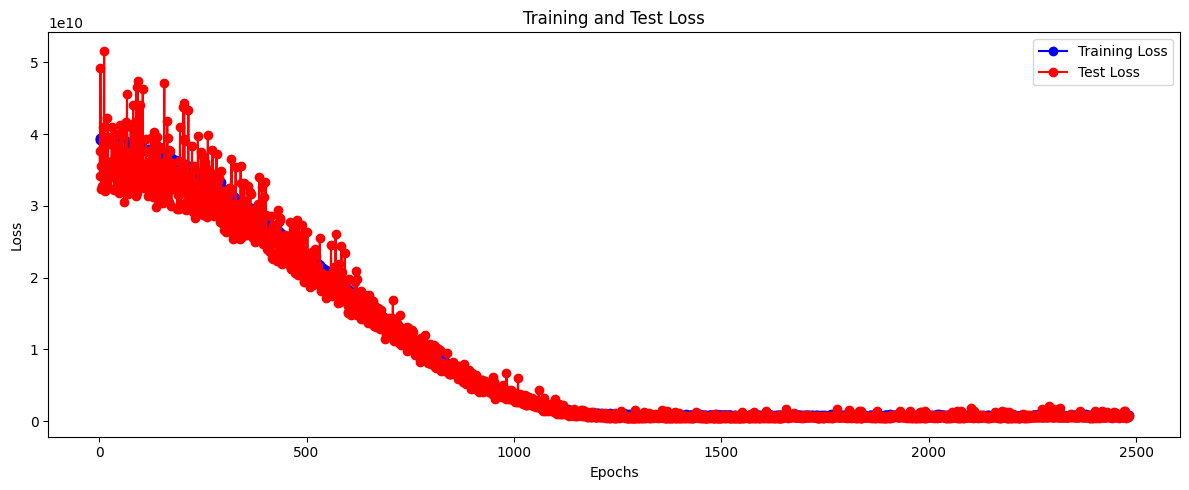

In [18]:
plot_training_results(train_losses, test_losses)

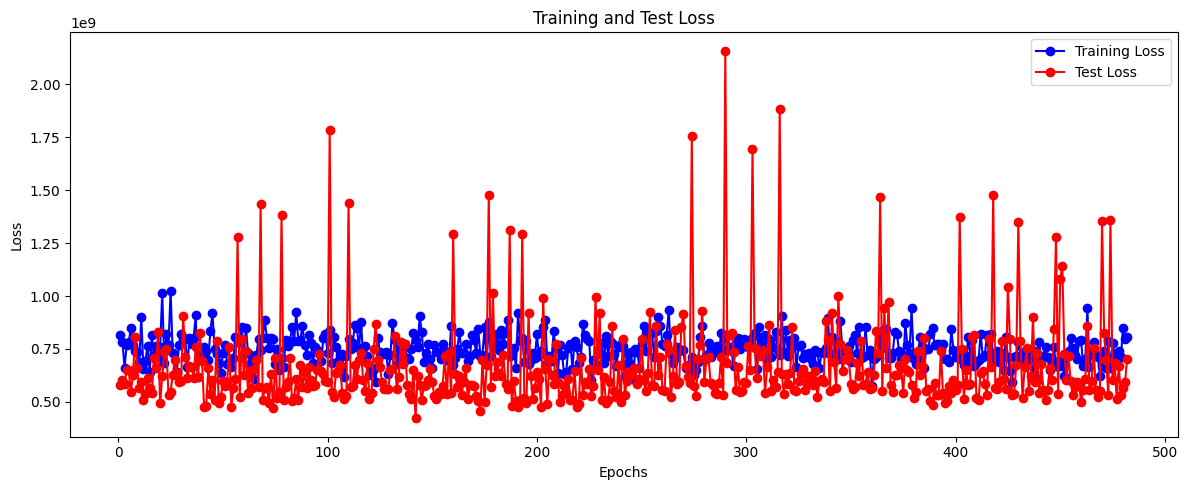

In [19]:
plot_training_results(train_losses[2000:], test_losses[2000:])

In [20]:
# 사용자명을 입력하세요. (이름이 아니여도 괜찮습니다.)
username = "김재곤"
assert username, "username 변수에 값이 설정되지 않았습니다."

# 그대로 실행하세요.
from JAEN.competition import Competition
comp = Competition(
    username=username,
    course_name='AI Essential',
    course_round='0317(1)',
    competition_name='House Price Prediction'
)

# 학습된 모델의 TEST 예측
model.eval()
TEST2 = TEST.to(device)
with torch.no_grad():
    outputs = model(TEST2)
outputs

# comp.prediction에 TEST 예측 결과 대입
comp.prediction = outputs
comp.prediction

# 제출
#comp.submit()

tensor([[114361.8828],
        [164212.7031],
        [182608.0938],
        ...,
        [160107.6719],
        [146548.5312],
        [270147.9688]], device='cuda:0')